In [1]:
import sys
sys.path.insert(0, "..")

In [2]:
from utils import access_raster
from glob import glob
import re
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.stats import gaussian_kde
import seaborn as sns
import random
from scipy import optimize

In [3]:
basepath = "/home/abetatos/Escritorio/TFM_Dataset/3.Basedataset/"
aspect_path = basepath + "TPIWGW"
hs_path = basepath + "HS"

is_tiff = lambda x: re.search(".tiff?$", x)

def get_dataframe(path, key): 
    files = filter(is_tiff, glob(path + "/**/*", recursive=True))
    df = pd.DataFrame(files, columns=[key])
    df['file'] = df[key].apply(lambda p: Path(p).parts[-2])
    df = df.set_index("file")
    return df

def get_array(raster): 
    array = raster['array'][0]
    nodata = raster['meta']['nodata']
    array[array==nodata]=0
    return array

In [4]:
df = get_dataframe(aspect_path, "TPIWGW")[1:]
df['HS'] = get_dataframe(hs_path, "HS")['HS']
len(df)

15

In [5]:
def get_mapping(series):
    aspect_raster = access_raster(series['TPIWGW'])
    hs_raster = access_raster(series['HS'])

    aspect_array = get_array(aspect_raster)
    hs_array = get_array(hs_raster)
    
    mapping = [[a, hs] for aspect_line, hs_line in zip(aspect_array, hs_array) 
                       for a, hs in zip(aspect_line, hs_line)
                       if hs > 0]
    
    return mapping

        
def fit_curve(x, y, ax): 
    def test_func(x, a, b, c, d):
        return a / (1 + np.exp(c*(x - d))) + b

    try:
        params, params_covariance = optimize.curve_fit(test_func, x, y, p0=[1, 0, 1, 0],
                                                    method="trf", absolute_sigma=True, maxfev=5000)
    except RuntimeError: 
        print("Optimal parameters not found, fit won't be displayed")
        plt.show()
        return None
        

    x, y = zip(*sorted(zip(x, y)))
    x, y = np.array(x), np.array(y)
    fitted_y = test_func(x, params[0], params[1], params[2], params[3])
    ax.plot(x, fitted_y,
            label='Linear regression', color="red")
    ax.legend(loc='best')
    plt.show()    
    
    get_str = lambda x:  f"{round(x, 2)}"
    a, b, c, d = params
    print(f"Fitted function: {get_str(a)} / (1 + np.exp({get_str(c)}*(x - {get_str(d)}))) + {get_str(b)}")
    
    
    mse = np.mean((y - fitted_y) ** 2)
    print("MSE:", mse)
    ss_res = np.sum((y - fitted_y) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_sq = 1 - (ss_res / ss_tot)
    print("R^2:", r_sq)
    
    return r_sq

def plot_map(_mapping):
    mapping = deepcopy(_mapping)
    random.shuffle(mapping)

    x, y = zip(*mapping[:10000])
    x, y = np.array(x), np.array(y)
    xy = np.vstack([x,y])
    kernel = gaussian_kde(xy)(xy)
    
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=kernel, s=1, label="scatter plot")
    
    fit_curve(x, y, ax)
    
    return x

def plot_slices(mapping): 
    df = pd.DataFrame(mapping)
    df[0] = df[0].apply(lambda x: round(x, 2))
    new_mapping = df.groupby(0).apply(np.mean, axis=0).values

    plot_map(new_mapping)
    return df

In [6]:
df

,TPIWGW,HS
file,,
HS_Saflischpass_20220512_1m_epsg2056,/home/abetatos/Escritorio/TFM_Dataset/3.Baseda...,/home/abetatos/Escritorio/TFM_Dataset/3.Baseda...
HS_Laucherenalp_20220511_1m_epsg2056,/home/abetatos/Escritorio/TFM_Dataset/3.Baseda...,/home/abetatos/Escritorio/TFM_Dataset/3.Baseda...
snowmap_2014_ads_100_extent_maskiert_nosnow0_noausreisser,/home/abetatos/Escritorio/TFM_Dataset/3.Baseda...,/home/abetatos/Escritorio/TFM_Dataset/3.Baseda...
HS_Davos_20200406_2m_epsg2056,/home/abetatos/Escritorio/TFM_Dataset/3.Baseda...,/home/abetatos/Escritorio/TFM_Dataset/3.Baseda...
HS_Davos_20211604_2m_epsg2056,/home/abetatos/Escritorio/TFM_Dataset/3.Baseda...,/home/abetatos/Escritorio/TFM_Dataset/3.Baseda...
snowmap_2013_ads_80_extent_maskiert_nosnow0_noausreisser,/home/abetatos/Escritorio/TFM_Dataset/3.Baseda...,/home/abetatos/Escritorio/TFM_Dataset/3.Baseda...
snowmap_2012_ads_80_extent_maskiert_nosnow0_noausreisser,/home/abetatos/Escritorio/TFM_Dataset/3.Baseda...,/home/abetatos/Escritorio/TFM_Dataset/3.Baseda...
snowmap_2015_ads_100_extent_maskiert_nosnow0_noausreisser,/home/abetatos/Escritorio/TFM_Dataset/3.Baseda...,/home/abetatos/Escritorio/TFM_Dataset/3.Baseda...
snowmap_20160126_ads_100_extent_maskiert_nosnow0_noausreisser,/home/abetatos/Escritorio/TFM_Dataset/3.Baseda...,/home/abetatos/Escritorio/TFM_Dataset/3.Baseda...


____________________________________________________________________________________________________ 
 HS_Saflischpass_20220512_1m_epsg2056


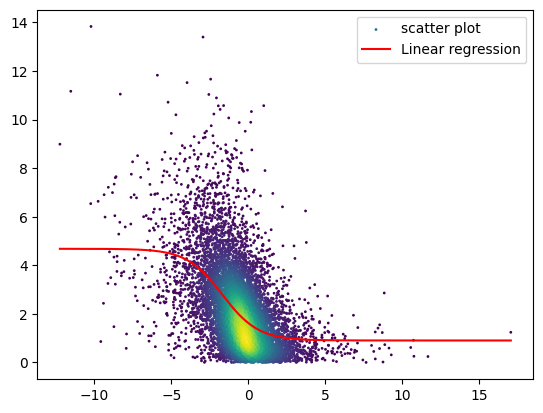

Fitted function: 3.78 / (1 + np.exp(0.86*(x - -1.68))) + 0.91
MSE: 1.9663953
R^2: 0.2849048376083374


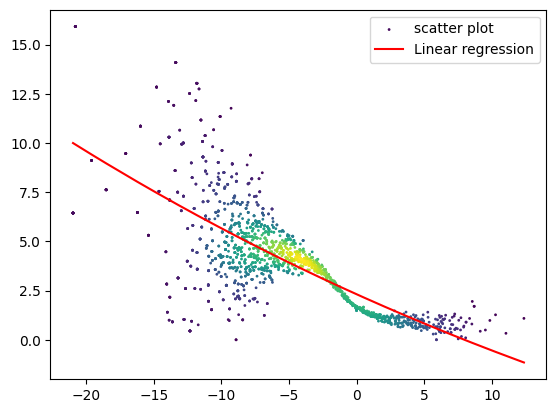

Fitted function: 283.46 / (1 + np.exp(0.02*(x - -146.54))) + -15.64
MSE: 3.444658266078366
R^2: 0.49342441770038137
____________________________________________________________________________________________________ 
 HS_Laucherenalp_20220511_1m_epsg2056


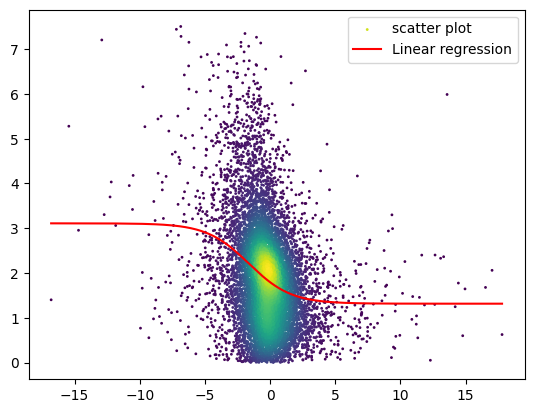

Fitted function: 1.8 / (1 + np.exp(0.62*(x - -1.63))) + 1.31
MSE: 1.2323946
R^2: 0.0908358097076416


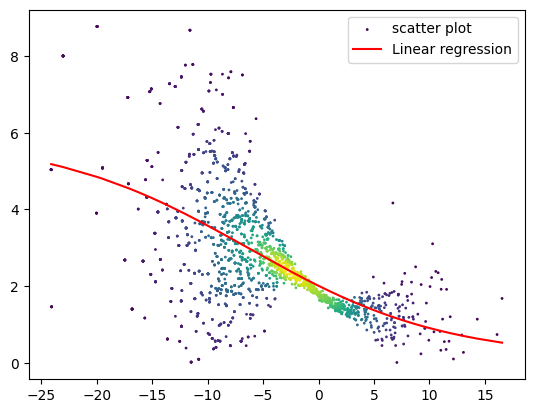

Fitted function: 5.74 / (1 + np.exp(0.11*(x - -6.32))) + 0.12
MSE: 1.686006359374234
R^2: 0.31441777752388644
____________________________________________________________________________________________________ 
 snowmap_2014_ads_100_extent_maskiert_nosnow0_noausreisser


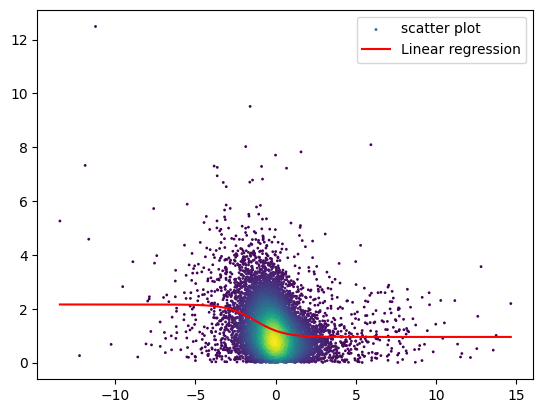

Fitted function: 1.21 / (1 + np.exp(1.14*(x - -1.26))) + 0.95
MSE: 0.801009
R^2: 0.08938884735107422


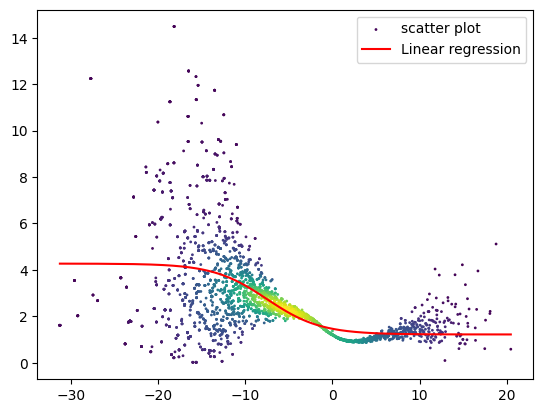

Fitted function: 3.05 / (1 + np.exp(0.32*(x - -7.53))) + 1.22
MSE: 3.130708730742038
R^2: 0.2785706976783352
____________________________________________________________________________________________________ 
 HS_Davos_20200406_2m_epsg2056


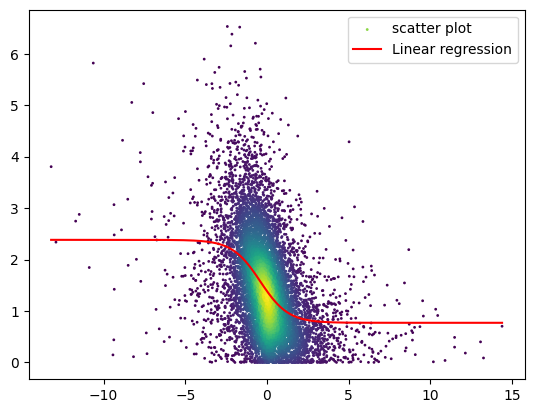

Fitted function: 1.61 / (1 + np.exp(1.17*(x - -0.41))) + 0.77
MSE: 0.7155344
R^2: 0.2009323239326477


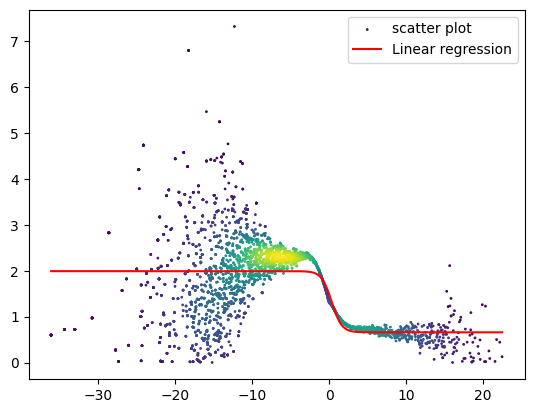

Fitted function: 1.33 / (1 + np.exp(1.54*(x - 0.33))) + 0.66
MSE: 0.622475685254574
R^2: 0.2925654871298775
____________________________________________________________________________________________________ 
 HS_Davos_20211604_2m_epsg2056


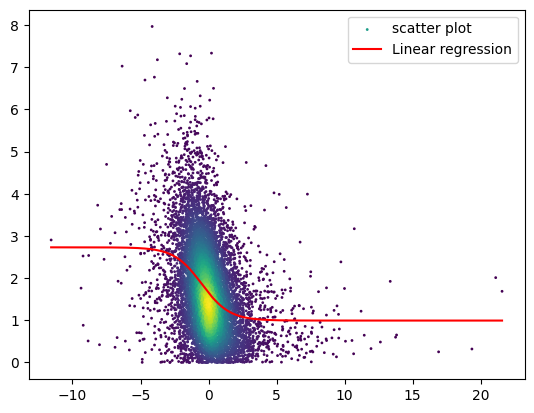

Fitted function: 1.74 / (1 + np.exp(0.98*(x - -0.5))) + 0.99
MSE: 0.9659965
R^2: 0.1518416404724121


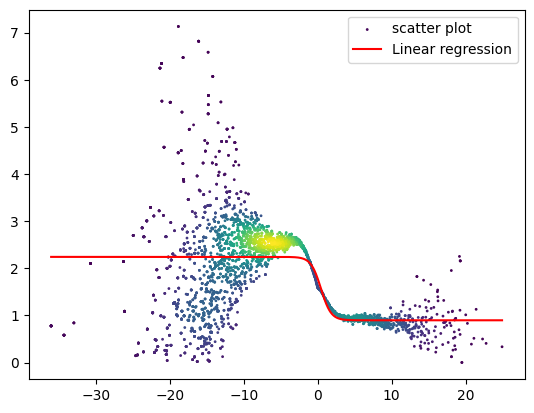

Fitted function: 1.35 / (1 + np.exp(1.47*(x - 0.41))) + 0.9
MSE: 0.8316040853662426
R^2: 0.23570426086087004
____________________________________________________________________________________________________ 
 snowmap_2013_ads_80_extent_maskiert_nosnow0_noausreisser


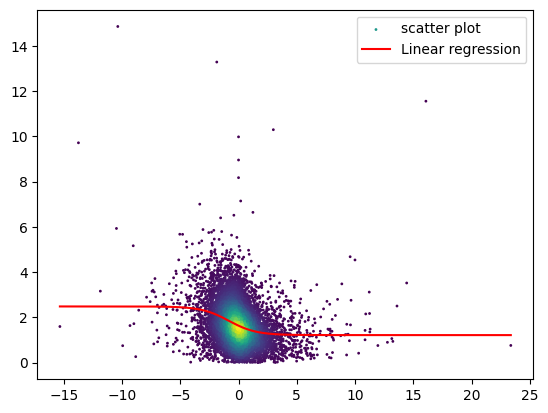

Fitted function: 1.27 / (1 + np.exp(0.85*(x - -0.84))) + 1.21
MSE: 0.7353944
R^2: 0.09186172485351562


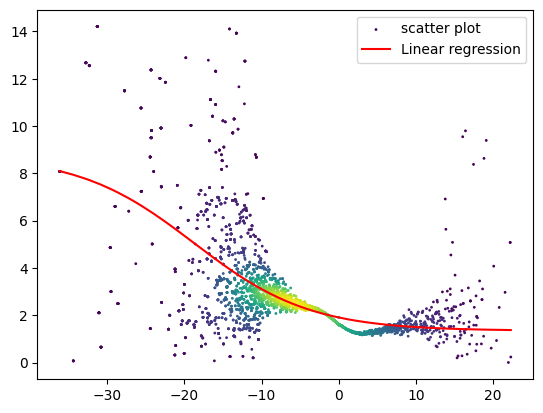

Fitted function: 7.42 / (1 + np.exp(0.13*(x - -18.75))) + 1.34
MSE: 3.423818032589612
R^2: 0.349738898524521
____________________________________________________________________________________________________ 
 snowmap_2012_ads_80_extent_maskiert_nosnow0_noausreisser


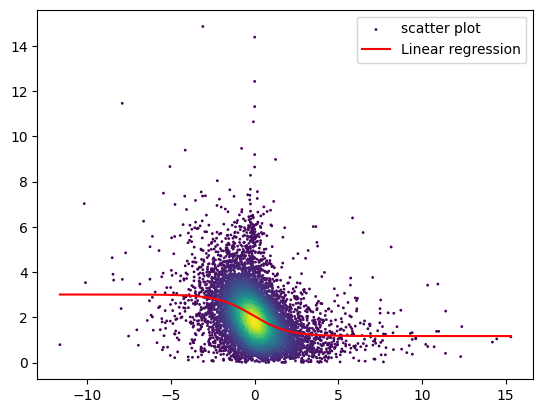

Fitted function: 1.84 / (1 + np.exp(0.94*(x - -0.1))) + 1.17
MSE: 1.197526
R^2: 0.13757753372192383


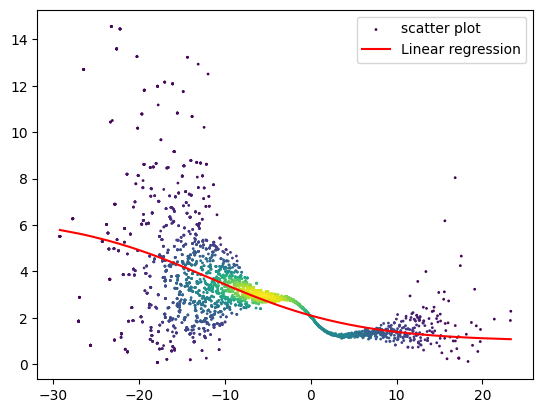

Fitted function: 5.42 / (1 + np.exp(0.12*(x - -11.64))) + 0.98
MSE: 2.9583526207294923
R^2: 0.2949707909348537
____________________________________________________________________________________________________ 
 snowmap_2015_ads_100_extent_maskiert_nosnow0_noausreisser


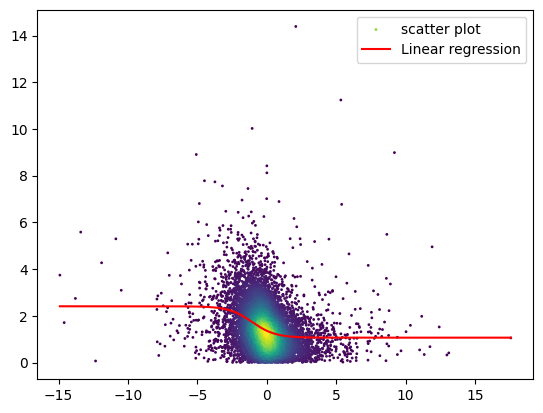

Fitted function: 1.34 / (1 + np.exp(1.19*(x - -1.07))) + 1.06
MSE: 0.90543485
R^2: 0.10426729917526245


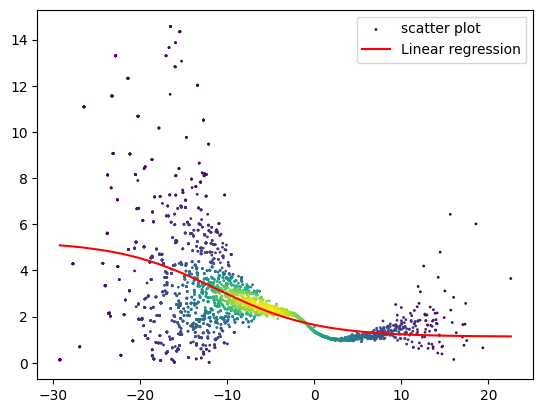

Fitted function: 4.13 / (1 + np.exp(0.17*(x - -11.2))) + 1.13
MSE: 3.3866113071759987
R^2: 0.24638129190791191
____________________________________________________________________________________________________ 
 snowmap_20160126_ads_100_extent_maskiert_nosnow0_noausreisser


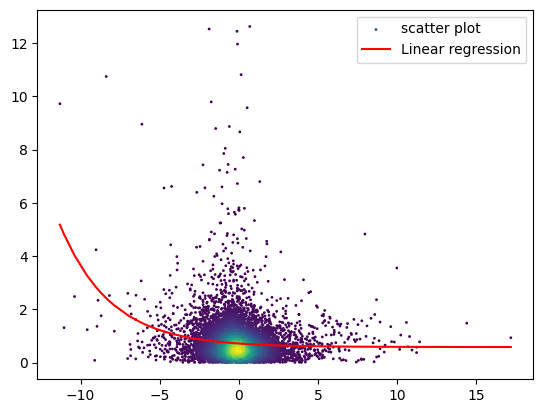

Fitted function: 1745.53 / (1 + np.exp(0.31*(x - -30.21))) + 0.58
MSE: 0.53134865
R^2: 0.027938127517700195


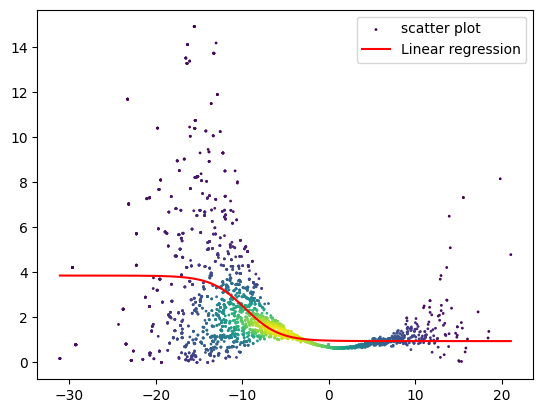

Fitted function: 2.91 / (1 + np.exp(0.51*(x - -9.67))) + 0.95
MSE: 3.8797709287494864
R^2: 0.24852911616818463
____________________________________________________________________________________________________ 
 HS_c_20220223_1m_epsg2056


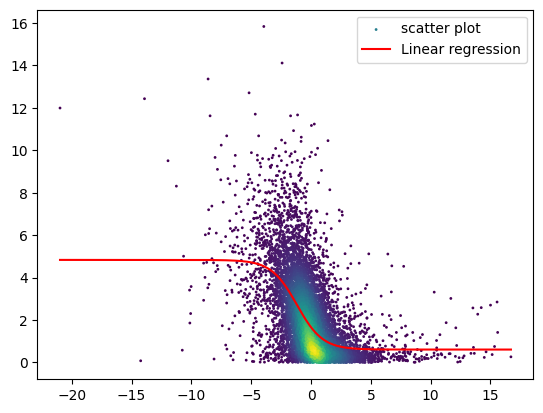

Fitted function: 4.22 / (1 + np.exp(0.93*(x - -1.18))) + 0.61
MSE: 2.3261325
R^2: 0.3315311670303345


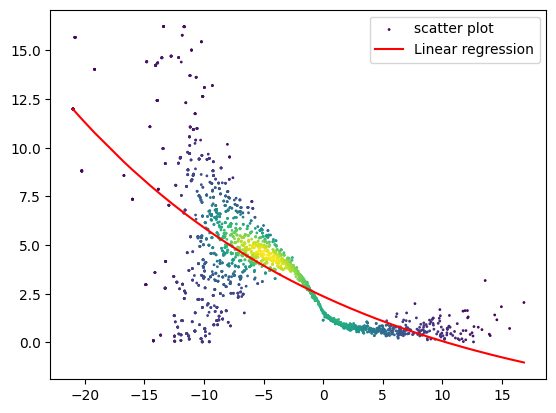

Fitted function: 2130.17 / (1 + np.exp(0.04*(x - -134.23))) + -4.24
MSE: 6.114906837167311
R^2: 0.41999077500364657
____________________________________________________________________________________________________ 
 HS_Davos_20170316_2m_epsg2056


In [7]:
for index, series in df.iterrows(): 
    print("_"*100, "\n", series.name)
    mapping = get_mapping(series)
    plot_map(mapping)
    new_mapping = plot_slices(mapping)